In [49]:
import geopy.distance
import json
import os
import pandas as pd
import time

from dotenv import load_dotenv
from shapely.geometry import Point, Polygon
from openrouteservice import client, directions, isochrones

In [2]:
output_dir = '../data/curated/'

## set variables
load_dotenv()
tokens = []
for i in range(1,24): # number of keys
    token = os.environ.get(f'token_{i}')
    tokens.append(token)
nearby_properties = {}

In [3]:
## read  data
property_data = json.load(open( f"{output_dir}properties_processed.json" ))
school_data = pd.read_csv(f'{output_dir}schools/school_info.csv')
filtered_schools = school_data[(school_data['School_Type'] == 'Primary')|(school_data['School_Type'] =='Pri/Sec')|(school_data['School_Type'] == 'Secondary')]

In [ ]:
## for each school find the properties in 30 min driving distance
token = tokens[0]

for index, row in filtered_schools.iterrows():
    school_coords = [row['Longitude'], row['Latitude']]
    school_key = f"{row['School_Type']}, {school_coords}"

    ## marker since num schools > isochrone quota
    if school_key not in nearby_properties.keys():
        ors = client.Client(key=token)

        ## find search region
        params_iso = {'locations': [school_coords],
                    'profile': 'driving-car',
                    'range':[1800] # 30 mins
                    }
        iso = ors.isochrones(**params_iso)['features'][0]['geometry']

        for property in property_data['Coordinates'].keys():
            backwards = list(map(float,property_data['Coordinates'][str(index)][1:-1].split(',')))
            coords = [backwards[1], backwards[0]]
            if shape(iso).contains(Point(tuple(coords))):
                if school_key in nearby_properties.keys():
                    nearby_properties[school_key].append(property)
                else:
                    nearby_properties[school_key] = [property]

In [44]:
token = tokens[1]
school = school_data.iloc[2181]
school_coords = [row['Longitude'], row['Latitude']]
school_key = f"{row['School_Type']}, {school_coords}"

ors = client.Client(key=token)
params_iso = {'locations': [school_coords],
                    'profile': 'driving-car',
                    'range':[1800] # 30 mins
                    }
iso = ors.isochrones(**params_iso)['features'][0]['geometry']

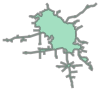

In [55]:
Polygon(iso['coordinates'][0])

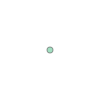

In [58]:
backwards = list(map(float,property_data['Coordinates'][str(index)][1:-1].split(',')))
coords = Point(backwards[1], backwards[0])
coords

In [ ]:
properties = {}
for property in property_data['Coordinates'].keys():
    backwards = list(map(float,property_data['Coordinates'][str(index)][1:-1].split(',')))
    coords = Point(backwards[1], backwards[0])
    print(Polygon(iso['coordinates'][0]).contains(coords))
    if coords.within(Polygon(iso['coordinates'][0])):
        if school_key in properties.keys():
            properties[school_key].append(property)
        else:
            properties[school_key] = [property]

In [62]:
properties

{}

In [ ]:
## reverse to find the schools within a 30 min drive
nearby_schools = {}
for property in property_data['Coordinates'].keys():
    for school in nearby_properties.keys():
        if property in nearby_properties[school]:
            if property in nearby_schools.keys():
                nearby_schools[property].append(school)
            else:
                nearby_schools[property] = [school]

In [ ]:
def get_closest(property, schools):
    prop_coords = tuple(property)
    if len(schools) == 0:
        return 0
    
    distances = []
    for school in schools:
        distances.append(geopy.distance.geodesic(prop_coords, tuple(school)))
    
    return schools[distances.index(min(distances))]

In [ ]:
def get_route(start, end):
    if end == 0:
        return {'distance': '0', 'duration':'0'}
    
    coords = [tuple(start), tuple(end)]
    ors = client.Client(key=token)
    request = {'coordinates': coords,
            'profile': 'driving-car',
            'geometry': 'true',
            'format_out':'geojson'}
    route = ors.directions(**request)
    return route['features'][0]['properties']['summary']

In [ ]:
## find nearest schools
school_dist = {}
for property in nearby_schools.keys():
    value = nearby_schools[property]
    backwards = list(map(float,property_data['Coordinates'][str(property)][1:-1].split(',')))
    prop_coords = [backwards[1], backwards[0]]

    ## separate school types
    pri_sec = [y for x,y in value if x=='Pri/Sec']
    pri = [y for x,y in value if x=='Primary']
    sec = [y for x,y in value if x=='Secondary']

    ## find closest school
    pri_sec_school = get_closest(prop_coords,pri_sec)
    pri_school = get_closest(prop_coords,pri)
    sec_school = get_closest(prop_coords,sec)

    ## get route to closest school
    pri_sec_route = get_closest(prop_coords,pri_sec_school)
    pri_route = get_closest(prop_coords,pri_school)
    sec_route = get_closest(prop_coords,sec_school)

    ## save information
    if (pri_sec_route['duration'] < pri_route['duration']) & (pri_sec_route['duration']!=0) | (pri_sec_route['duration'] > pri_route['duration']) & (pri_sec_route['duration']==0):
        school_dist[property]['Primary'] = pri_sec_route
    else:
        school_dist[property]['Primary'] = pri_route
    
    if (pri_sec_route['duration'] < sec_route['duration']) & (pri_sec_route['duration']!=0) | (pri_sec_route['duration'] > sec_route['duration']) & (pri_sec_route['duration']==0):
        school_dist[property]['Secondary'] = pri_sec_route
    else:
        school_dist[property]['Secondary'] = sec_route